## Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

In [ ]:
LCNNatchsize=512

LCNNsettast = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
LCNNload = torch.utils.data.DataLoader(trainset, batch_size=LCNNatchsize, shuffle=False)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=32

trainset = datasets.FashionMNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.FashionMNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

# 2 layers Full batch

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

num_classes = 10


class NeuralNet2layer(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=False):
        super(NeuralNet2layer, self).__init__()
        self.initialize=initialize
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.batchnorm = batchnorm


        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)


        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        if self.initialize=='NTK':

            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)




    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        else:

            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
        return out
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot,adjust_

In [ ]:
rt=100000
outlist=[]
for index in [0,1]:
    losslist=[]
    aclist=[]
    learning_rate = 0.1
    torch.manual_seed(0)
    batchnorm=False

    if index >2:
        batchnorm=True
    device = torch.device('cuda')
    model = NeuralNet2layer(input_size, hidden_size1,num_classes, initialize='LeCun',batchnorm=batchnorm).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)

    loo=1
    lo=1
    rep=False
    scale=1.2
    therd=0.6
    for runsteps in range(2000):





        if (runsteps==2 and index ==0):
            model.fc1.register_forward_hook(get_activation('fc1'))
            outputs=model(images).to(device)
            adjust_(model,activation['fc1'],images,threshold_u=1.0/therd,threshold_l=therd,scale=scale,ln=1,oflag=2,mode=0,shuff=index)

        if (runsteps==0 and index ==2) or (index==4 and runsteps==2):
            model.fc1.register_forward_hook(get_activation('fc1'))
            outputs=model(images).to(device)
            adjust_(model,activation['fc1'],images,threshold_u=1.0/therd,threshold_l=therd,scale=scale,ln=1,oflag=2,mode=1,shuff=index)


        
        loo=lo
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0 or runsteps<10:
            #print(index,runsteps,lo)
            pass

        if lo<0.00001:
            if rt>runsteps:
                rt=runsteps
                sb=scale
                tb=therd
            print(scale,therd,runsteps,lo)
            c=accuracy(model,valloader)
            ac=1
            aclist.append(ac)
            break
    outlist.append([losslist,aclist])

tensor([0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000,
        0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000,
        0.6000, 0.6462, 1.6667, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000,
        0.6000, 1.6667, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 1.6667, 0.6000,
        0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 1.6667, 0.6000, 0.6000, 0.6000,
        0.6000, 0.6000, 0.6000, 0.6000, 1.6667, 0.8353, 0.6000, 0.7278, 0.6000,
        1.2154, 0.6000, 0.6000, 1.6667, 0.6000, 1.6667, 1.6667, 0.6000, 0.6000,
        0.6000, 1.6667, 1.6667, 0.6000, 1.6667, 1.6667, 0.6000, 0.6000, 0.6000,
        0.6000, 1.6667, 0.6000, 0.6000, 0.6000, 0.6000, 1.1357, 1.6667, 0.6000,
        0.6000, 1.6477, 0.6000, 0.6000, 0.6000, 0.6000, 0.7667, 0.6000, 0.6000,
        0.6000, 0.6000, 0.6000, 1.6667, 0.6000, 1.6667, 1.2996, 0.6000, 0.6000,
        0.6000, 0.6000, 1.6667, 1.4815, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000,
        0.6000, 1.6667, 0.6000, 0.6000, 

In [ ]:
rt=100000
outlist=[]
for scale in range(10):
    scale=(scale-5)*0.1+0.5
    for therd in range(10):
        therd=(therd-5)*0.1+0.55
        index=0
        losslist=[]
        aclist=[]
        learning_rate = 0.1
        torch.manual_seed(0)
        batchnorm=False

        if index >2:
            batchnorm=True
        device = torch.device('cuda')
        model = NeuralNet2layer(input_size, hidden_size1,num_classes, initialize='LeCun',batchnorm=batchnorm).to(device)

        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
        criterion = nn.MSELoss()

        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1).to(device)
        labels =one_hot(labels,num_classes).to(device)

        loo=1
        lo=1
        for runsteps in range(2000):





            if (runsteps==2 and index ==0):
                model.fc1.register_forward_hook(get_activation('fc1'))
                outputs=model(images).to(device)
                adjust_(model,activation['fc1'],images,threshold_u=1.0/therd,threshold_l=therd,scale=scale,ln=1,oflag=0,mode=1,shuff=index)

            if (runsteps==0 and index ==2) or (index==4 and runsteps==2):
                model.fc1.register_forward_hook(get_activation('fc1'))
                outputs=model(images).to(device)
                adjust_(model,activation['fc1'],images,threshold_u=1.0/therd,threshold_l=therd,scale=scale,ln=1,oflag=0,mode=1,shuff=index)


            
            loo=lo
            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lo=loss.item()


            losslist.append(lo)
            if runsteps%10==0 or runsteps<10:
                #print(index,runsteps,lo)
                pass

            if lo<0.00001:
                if rt>runsteps:
                    rt=runsteps
                    sb=scale
                    tb=therd
                print(scale,therd,runsteps,lo)
                c=accuracy(model,valloader)
                aclist.append(ac)
                break
        outlist.append([losslist,aclist])

print(rt,sb,tb)

0.0 0.25 1184 9.9873541330453e-06
Accuracy: 56.7100 %
0.0 0.35000000000000003 482 9.9994085758226e-06
Accuracy: 58.6600 %
0.0 0.45000000000000007 161 9.903565114655066e-06
Accuracy: 61.9800 %
0.0 0.55 93 9.324307029601187e-06
Accuracy: 63.6500 %
0.0 0.65 93 9.94078436633572e-06
Accuracy: 64.3700 %
0.0 0.75 95 9.806800335354637e-06
Accuracy: 65.2500 %
0.0 0.8500000000000001 95 9.337994924862869e-06
Accuracy: 65.6100 %
0.0 0.9500000000000001 97 9.682867130322848e-06
Accuracy: 65.8800 %
0.09999999999999998 0.25 1020 9.978523848985787e-06
Accuracy: 57.7800 %
0.09999999999999998 0.35000000000000003 391 9.966907782654744e-06
Accuracy: 60.1100 %
0.09999999999999998 0.45000000000000007 155 9.79058586381143e-06
Accuracy: 61.7800 %
0.09999999999999998 0.55 91 9.713384315546136e-06
Accuracy: 63.6800 %
0.09999999999999998 0.65 94 9.358850547869224e-06
Accuracy: 64.3100 %
0.09999999999999998 0.75 91 9.450526704313233e-06
Accuracy: 65.2600 %
0.09999999999999998 0.8500000000000001 95 9.38450557441683

In [ ]:
mode 0 87 1.454 0.54


TypeError: ignored

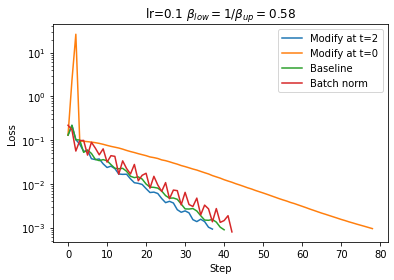

In [ ]:
# plot loss
plt.plot(outlist[0][0],'-',label='Modify at t=2')
plt.plot(outlist[2][0],'-',label='Modify at t=0')
plt.plot(outlist[1][0],'-',label='Baseline')
plt.plot(outlist[3][0],'-',label='Batch norm')
#plt.plot(outlist[4][0],'-',label='Batch norm+modificaiton')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.ylim([0,0.15])
#plt.xlim([-3,55])
plt.yscale('log')

plt.title(r'lr=0.1 $\beta_{low}=1/\beta_{up}=$'+str(therd))
plt.savefig('/content/drive/My Drive/LCNN/newplots/jinji16.pdf')

IndexError: ignored

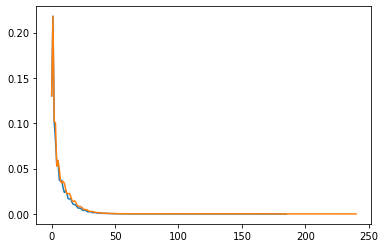

In [ ]:
# plot loss
plt.plot(outlist[0][0],'-',label=r'$\beta=\beta_{low}$')
plt.plot(outlist[1][0],'-',label=r'$\beta=\beta_{up}$')
plt.plot(outlist[2][0],'-',label=r'$\beta=1 / \beta_m$')
plt.plot(outlist[3][0],'-',label=r'$\beta=\beta_m$')
plt.plot(outlist[4][0],'-',label='original')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
plt.ylim([0,0.15])
plt.xlim([-3,55])

plt.title(r'lr=0.05 $\beta_{low}=1/\beta_{up}=$'+str(therd))
plt.savefig('/content/drive/My Drive/LCNN/newplots/jinji16.pdf')

In [ ]:
outlist=[]
for index in [-1,0,1,2]:
# Index= -1, Original
#      = 0 Our modification
#      = 1 Bathnorm
#.     = 2 Our modification+Our modification
    learning_rate = 0.5
    torch.manual_seed(0)
    batchnorm=False
    if index==1 or index==2:
        batchnorm=True
    device = torch.device('cuda')
    model = NeuralNet2layer(input_size, hidden_size1,num_classes, initialize='NTK',batchnorm=batchnorm).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    aclist=[]

    
    for runsteps in range(1000*20):
        if (index==0 or index==2) and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.2,ln=1,oflag=1,mode=2)
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(index,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.01:
            break
    outlist.append([losslist,aclist])

-1 0 0.16779623925685883
Accuracy: 8.8100 %
-1 10 0.10054086893796921


KeyboardInterrupt: ignored

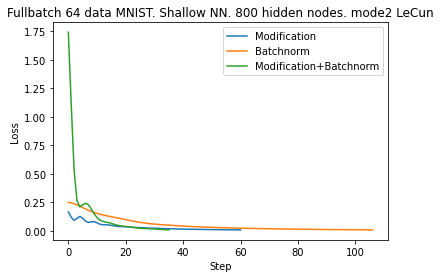

In [ ]:
# plot loss
#plt.plot(outlist[0][0],'-',label='Original')
plt.plot(outlist[1][0],'-',label='Modification')
plt.plot(outlist[2][0],'-',label='Batchnorm')
plt.plot(outlist[3][0],'-',label='Modification+Batchnorm')

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('Fullbatch 64 data MNIST. Shallow NN. 800 hidden nodes. mode2 LeCun')
plt.savefig('/content/drive/My Drive/LCNN/newplots/2.pdf')

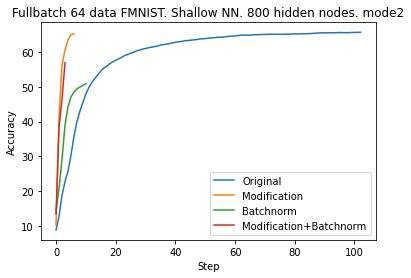

In [ ]:
# plot accuracy
plt.plot(outlist[0][1],'-',label='Original')
plt.plot(outlist[1][1],'-',label='Modification')
plt.plot(outlist[2][1],'-',label='Batchnorm')
plt.plot(outlist[3][1],'-',label='Modification+Batchnorm')

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('Fullbatch 64 data FMNIST. Shallow NN. 800 hidden nodes. mode2')
plt.savefig('/content/drive/My Drive/LCNN/newplots/3.pdf')

# 4 layers Minibatch

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10



class NeuralNet4layer(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,initialize='NTK',batchnorm=False):
        super(NeuralNet4layer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)
        self.input_size=input_size
        self.hidden_size1=hidden_size1
        self.hidden_size2=hidden_size2
        self.hidden_size3=hidden_size3
        self.batchnorm=batchnorm
        self.initialize=initialize

        if self.batchnorm:
            self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
            self.bn2 = nn.BatchNorm1d(num_features=hidden_size3)
        
        if self.initialize=='NTK':
            self.fc1.weight.detach().uniform_(-1, 1)
            self.fc1.bias.detach().uniform_(-1, 1)
            self.fc2.weight.detach().uniform_(-1,1)
            self.fc3.weight.detach().uniform_(-1, 1)
            self.fc3.bias.detach().uniform_(-1, 1)
            self.fc4.weight.detach().uniform_(-1,1)

    def forward(self, x):
        if self.batchnorm:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = self.fc3(out)
                out = self.bn2(out)
                out = self.relu2(out)
                out = self.fc4(out)
            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.bn1(out)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
                out = self.fc3(out)
                out = out/np.sqrt(self.hidden_size2)
                out = self.bn2(out)
                out = self.relu2(out)
                out = self.fc4(out)
                out = out/np.sqrt(self.hidden_size3)
        else:
            if self.initialize=='LeCun':
                out = self.fc1(x)
                out = self.relu1(out)
                out = self.fc2(out)
                out = self.fc3(out)
                out = self.relu2(out)
                out = self.fc4(out)

            if self.initialize=='NTK':
                out = self.fc1(x)
                out = out/np.sqrt(self.input_size)
                out = self.relu1(out)
                out = self.fc2(out)
                out = out/np.sqrt(self.hidden_size1)
                out = self.fc3(out)
                out = out/np.sqrt(self.hidden_size2)
                out = self.relu2(out)
                out = self.fc4(out)
                out = out/np.sqrt(self.hidden_size3)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
outlist=[]
for index in [-1,0]:
# Index= -1, Original
#      = 0 Our modification
#      = 1 Bathnorm
#.     = 2 Our modification+Our modification
    learning_rate = 0.1
    torch.manual_seed(0)
    batchnorm=False
    if index==1 or index==2:
        batchnorm=True
    device = torch.device('cuda')
    print(batchnorm)
    model = NeuralNet4layer(input_size,hidden_size1,hidden_size2,hidden_size3,initialize='LeCun', batchnorm=batchnorm).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    losslist=[]
    aclist=[]
    steploss=[]
    num_epochs=10000
    

    therd=0.99
    for epoch in range(num_epochs):
        loss_epoch=0
        count=0

        for i, (images, labels) in enumerate(train_loader):
            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)

            #if (index==0 or index==2) and (i==2 and epoch==0):
            if (index==0 or index==2) and (epoch==0):
                adjust(model,images,threshold_u=1/therd,threshold_l=therd,scale=1,ln=1,oflag=1,mode=2)
            if (index==0 or index==2) and (i==5 and epoch==-1):
                model.fc2.register_forward_hook(get_activation('fc2'))
                with torch.no_grad():
                    outputs = model(images)
                    adjust(model,activation['fc'+str(2)],threshold_u=1/therd,threshold_l=therd,scale=1,ln=3,oflag=1,mode=2) 
            if (count<10) and epoch==0:
                print(count,loss.item())
            count=count+1
            steploss.append(loss.item())
            loss_epoch=loss_epoch+loss.item()       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        if epoch %10 == 0:
            print(epoch)
            model.eval()
            ac=accuracy(model,valloader)
            aclist.append(ac)
            print ('{} Epoch [{}/{}], Loss: {:.4f}' .format(index, epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.01:
            print(epoch,count,loss.item(),loss_epoch)
            break
    outlist.append([losslist,steploss,aclist])

False
0 0.10614407062530518
1 0.09768159687519073
2 0.09161939471960068
3 0.08887773007154465
4 0.08984392136335373
5 0.0871981680393219
6 0.0875033289194107
7 0.08627458661794662
8 0.08624144643545151
9 0.08307548612356186
0
Accuracy: 94.8900 %
-1 Epoch [1/10000], Loss: 0.0217
1 938 0.0038077314384281635 0.009492946596546118
False
Adjusting Layer 1, Kernel Nodes: 441, Adptive Nodes:359
0 0.10614407062530518
Adjusting Layer 1, Kernel Nodes: 441, Adptive Nodes:359
1 0.09768741577863693
Adjusting Layer 1, Kernel Nodes: 445, Adptive Nodes:355
2 0.09163141250610352
Adjusting Layer 1, Kernel Nodes: 440, Adptive Nodes:360
3 0.08889506012201309
Adjusting Layer 1, Kernel Nodes: 432, Adptive Nodes:368
4 0.08985235542058945
Adjusting Layer 1, Kernel Nodes: 445, Adptive Nodes:355
5 0.08721303194761276
Adjusting Layer 1, Kernel Nodes: 428, Adptive Nodes:372
6 0.08753907680511475


KeyboardInterrupt: ignored

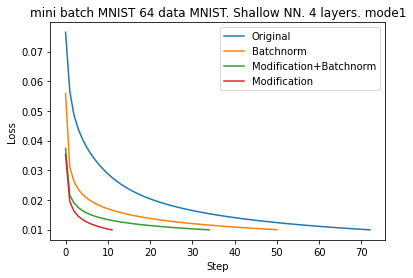

In [ ]:
# plot loss
plt.plot(outlist[0][0],'-',label='Original')

plt.plot(outlist[2][0],'-',label='Batchnorm')

plt.plot(outlist[3][0],'-',label='Modification+Batchnorm')

plt.plot(outlist[1][0],'-',label='Modification')

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('mini batch MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')
plt.savefig('/content/drive/My Drive/LCNN/plot/BN1.pdf')

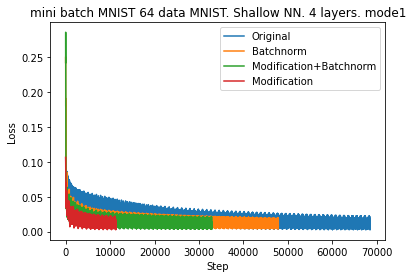

In [ ]:
# plot Step loss
plt.plot(outlist[0][1],'-',label='Original')
plt.plot(outlist[2][1],'-',label='Batchnorm')

plt.plot(outlist[3][1],'-',label='Modification+Batchnorm')
plt.plot(outlist[1][1],'-',label='Modification')



plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('mini batch MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')
plt.savefig('/content/drive/My Drive/LCNN/plot/BN2.pdf')

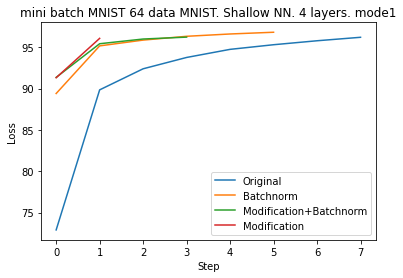

In [ ]:
# plot accuracy
plt.plot(outlist[0][2],'-',label='Original')

plt.plot(outlist[2][2],'-',label='Batchnorm')

plt.plot(outlist[3][2],'-',label='Modification+Batchnorm')
plt.plot(outlist[1][2],'-',label='Modification')

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')
#plt.xlim([0,100])

plt.title('mini batch MNIST 64 data MNIST. Shallow NN. 4 layers. mode1')
plt.savefig('/content/drive/My Drive/LCNN/plot/BN3.pdf')

In [ ]:
model.fc1.register_forward_hook(get_activation('fc1'))
outputs=model(images)


In [ ]:
d= activation['fc1']

In [ ]:
d.size()

torch.Size([64, 800])

In [ ]:
a.size()

torch.Size([64, 10])

In [ ]:
 model = NeuralNet4layer(input_size,hidden_size1,hidden_size2,hidden_size3,initialize='LeCun', batchnorm=batchnorm).to(device)

In [ ]:
model = NeuralNet2layer(input_size, hidden_size1,num_classes, initialize='LeCun',batchnorm=batchnorm).to(device)

In [ ]:
b=torch.sum(a,dim=0)

In [ ]:
ln=1

In [ ]:
b=model.state_dict()['fc'+str(ln)+'.bias']

In [ ]:
b.size()

torch.Size([800])

In [ ]:
(d/b).size()

torch.Size([64, 800])

In [ ]:
d=torch.tensor([[1,2],[3,4]])

In [ ]:
b=torch.tensor([2,4])

In [ ]:
b.size()

torch.Size([2])

In [ ]:
d.size()

torch.Size([2, 2])

In [ ]:
n=torch.norm(images,dim=1)

In [ ]:
x=d/b

In [ ]:
x.size()

torch.Size([64, 800])

In [ ]:
x/n

tensor([[ 0.0905,  2.0189, -1.5292,  ...,  0.9132, 57.3523, -0.9976],
        [ 1.7707,  0.8111, -2.4952,  ...,  1.3373, 34.9588,  0.2737],
        [ 1.5567,  1.8259, -1.6998,  ...,  1.5580,  1.4039,  0.4073],
        ...,
        [ 1.6667,  0.9311, -1.4586,  ..., -0.0609, -0.5191, -0.3619],
        [ 1.0581,  1.1980, -1.3371,  ..., -0.0649, 36.4679, -3.1207],
        [ 0.7608,  1.6505, -2.4519,  ...,  1.3015, 55.8026,  1.0133]])

In [ ]:
        b=model.state_dict()['fc'+str(ln)+'.bias']
        distance=torch.abs(d/b)/torch.norm(images,dim=1).reshape(len(images),-1)

In [ ]:
d=torch.mean(distance,dim=0)

In [ ]:
d_=(d-torch.mean(d))/torch.var(d)

In [ ]:
a=torch.norm(model.state_dict()['fc'+str(ln)+'.weight'],dim=1)

In [ ]:
b=torch.norm(model.state_dict()['fc'+str(ln)+'.bias'],dim=1)

In [ ]:
c=torch.norm(model.state_dict()['fc'+str(ln+1)+'.weight'],dim=0)

In [ ]:
c.size()

torch.Size([800])

In [ ]:
a=torch.norm(model.state_dict()['fc'+str(ln)+'.weight'][i])
b=torch.norm(model.state_dict()['fc'+str(ln)+'.bias'][i])
c=torch.norm(model.state_dict()['fc'+str(ln+1)+'.weight'][:,i])

det= torch.sqrt(c*c/len(model.state_dict()['fc'+str(ln+1)+'.weight'][:,i])/((b*b+a*a)/(len(model.state_dict()['fc'+str(ln)+'.weight'][i])+1)))


NameError: ignored

In [ ]:
clen=len(model.state_dict()['fc'+str(ln+1)+'.weight'][:,0])
alen=len(model.state_dict()['fc'+str(ln)+'.weight'][0])

a=torch.norm(model.state_dict()['fc'+str(ln)+'.weight'],dim=1).to(device)
b=torch.norm(model.state_dict()['fc'+str(ln)+'.bias'],dim=1).to(device)
c=torch.norm(model.state_dict()['fc'+str(ln+1)+'.weight'],dim=0).to(device)

det= ((c*c)/(clen))  /((a*a+b*b)/(alen+1))

IndexError: ignored

In [ ]:
torch.norm(model.state_dict()['fc'+str(ln)+'.bias'],dim=1).to(device)

IndexError: ignored

In [ ]:
            a=torch.norm(model.state_dict()['fc'+str(ln)+'.weight'],dim=1).to(device)
#            b=torch.norm(model.state_dict()['fc'+str(ln)+'.bias'],dim=1).to(device)
            c=torch.norm(model.state_dict()['fc'+str(ln+1)+'.weight'],dim=0).to(device)

In [ ]:
a.size()

torch.Size([800])

In [ ]:
b=model.state_dict()['fc'+str(ln)+'.bias'].to(device)

In [ ]:
b.size()

torch.Size([800])

In [ ]:
det= ((c*c)/(clen))  /((a*a+b*b)/(alen+1))

In [ ]:
det.size()

torch.Size([800])

In [ ]:
d_=d_*d_

In [ ]:
d_=d_/(det)

In [ ]:
d_.size()

torch.Size([800])

In [ ]:
clen=len(model.state_dict()['fc'+str(ln+1)+'.weight'][:,0])

In [ ]:
clen

10

In [ ]:
ln

1

In [ ]:
alen=len(model.state_dict()['fc'+str(ln)+'.weight'][0])

In [ ]:
alen

784

In [ ]:
torch.norm(model.state_dict()['fc'+str(ln)+'.weight'],dim=1).size()

torch.Size([800])

In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
x=torch.tensor([1,2,3])

In [ ]:
x[x>2]=1

In [ ]:
x

tensor([1, 2, 1])

In [ ]:
range(0,10,1)

range(0, 10)